# Task 1 Kuzushiji Kanji Classification
- 61070278
- 61070306
- 61070365

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, Input, UpSampling2D
from tensorflow.python.keras.layers import MaxPooling2D, BatchNormalization
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, Callback

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score#, confusion_matrix
from sklearn.preprocessing import normalize

C:\Users\user\anaconda3\envs\shine_env\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\user\anaconda3\envs\shine_env\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\user\anaconda3\envs\shine_env\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\user\anaconda3\envs\shine_env\lib\site-packages\tensorf

In [3]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

เช็คว่ามี GPU มั้ย เพราะถ้าใช้ GPU ในการคำนวณจะเร็วกว่าการใช้ CPU มากๆ

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17587244745636157317
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3069915955
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3349367025809373174
physical_device_desc: "device: 0, name: GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


## Load Data

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')
# X = np.load('/content/drive/MyDrive/Colab Notebooks/kuzushiji-ml-it-kmitl-2020/train-images.npy')
# y = np.load('/content/drive/MyDrive/Colab Notebooks/kuzushiji-ml-it-kmitl-2020/train-labels.npy')

In [7]:
X = np.load('train-images.npy')
y = np.load('train-labels.npy')

In [8]:
X.shape

(101376, 64, 64)

## Plot Some Samples of data

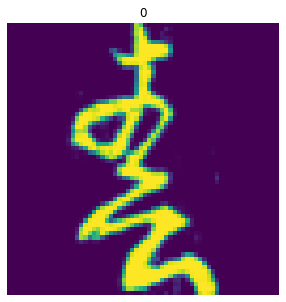

In [9]:
figsize = (5,5)
plt.figure(figsize=figsize)
plt.axis('off')
plt.title(y[0])
plt.imshow(X[0])

---

## Preprocessing

In [10]:
# ทำการ reshape ข้อมูล ปรับให้เป็น 4096 เพราะ 64*64
X_ = X.reshape(-1, 4096)

In [11]:
# เช็คค่ามากที่สุดและน้อยที่สุดเพื่อจะทำการปรับ scale ใหม่
print(X.max(), X.min())

255 0


ปรับ scale ข้อมูลเพื่อให้คอมพิวเตอร์ทำงานได้เร็วขึ้น

In [12]:
# ทำการปรับ scale ใหม่ให้อยู่ระหว่าง 0-1
X_ = X_ / 255

In [13]:
normalized_X = normalize(X_)
np.std(normalized_X)

0.013615821117607585

In [22]:
# ทำการ reshape ให้เหมาะสมกับอัลกอริทึม
X_norm = normalized_X.reshape(X_.shape[0], 64, 64, 1)
X_norm.shape

(101376, 64, 64, 1)

In [23]:
# ทำการแบ่งแยกข้อมูลเป็นส่วน train และ validation 
X_train, X_val, y_train, y_val = train_test_split(X_norm, y, test_size=0.1, random_state=42, stratify=y)
X_train.shape

(91238, 64, 64, 1)

---

In [25]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1*X GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=(1024*4))])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Define Model Architecture
ออกแบบ nn 

In [29]:
IMG_ROWS = X_train.shape[1]
IMG_COLS = X_train.shape[2]
NUM_CLASSES = len(np.unique(y_train))
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, 1)

print(NUM_CLASSES, INPUT_SHAPE)

1080 (64, 64, 1)


https://stackabuse.com/image-recognition-in-python-with-tensorflow-and-keras/

- activation จะเลือกใช้เป็น relu เพราะเป็นที่นิยมและมีคุณภาพ
- padding กำหนดให้เป็น same ซึ่งหมายถึงเราจะไม่เปลี่ยนขนาดของภาพ
- MaxPooling2D ลดขนาดอินพุต
- ใส่ dropout เพื่อไม่ให้โมเดล overfitting
- Batch Normalization จะทำให้อินพุตที่มุ่งหน้าไปยังเลเยอร์ถัดไปเป็นปกติ เพื่อให้แน่ใจว่าเครือข่ายจะมีการกระจายเดียวกันกับที่เราต้องการเสมอ
- Flatten เลเยอร์สุดท้ายของ CNN ต้องการให้ข้อมูลอยู่ในรูปของเวกเตอร์เพื่อประมวลผล ด้วยเหตุนี้ข้อมูลจึงต้องใช้ flatten เพื่อที่ค่าจะได้ถูกบีบอัดเป็นเวกเตอร์
- Dense อันสุดท้ายจะกำหนดให้มีจำนวนเท่ากับ Label ของเรา

In [30]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=INPUT_SHAPE, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.2))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.2))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.2))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.2))
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(rate=0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(rate=0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(BatchNormalization())

model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc']
              )

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [31]:
# Display the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0

In [32]:
# checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/kuzushiji-ml-it-kmitl-2020/model/cnn_weights_5.h5'
checkpoint_filepath = 'model/cnn_weights.h5'

In [33]:
checkpointer = ModelCheckpoint(filepath=checkpoint_filepath, verbose=1, 
                               monitor='val_loss',save_best_only=True, mode='min')

earlystoper = EarlyStopping(monitor='val_loss', patience=30) #ถ้าไม่ดีขึ้นใน 30 รอบให้หยุด

In [34]:
# fit the model
%time history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, verbose=1, callbacks=[checkpointer, earlystoper])

Train on 82114 samples, validate on 9124 samples
Epoch 1/100
82080/82114 [============================>.] - ETA: 0s - loss: 3.2027 - acc: 0.3985
Epoch 00001: val_loss improved from inf to 1.44981, saving model to model/cnn_weights_5.h5
82114/82114 [==============================] - 53s 646us/sample - loss: 3.2022 - acc: 0.3986 - val_loss: 1.4498 - val_acc: 0.6619
Epoch 2/100
82048/82114 [============================>.] - ETA: 0s - loss: 1.4428 - acc: 0.6577
Epoch 00002: val_loss improved from 1.44981 to 0.72851, saving model to model/cnn_weights_5.h5
82114/82114 [==============================] - 49s 594us/sample - loss: 1.4425 - acc: 0.6578 - val_loss: 0.7285 - val_acc: 0.8196
Epoch 3/100
82048/82114 [============================>.] - ETA: 0s - loss: 1.0057 - acc: 0.7471
Epoch 00003: val_loss improved from 0.72851 to 0.59142, saving model to model/cnn_weights_5.h5
82114/82114 [==============================] - 47s 566us/sample - loss: 1.0056 - acc: 0.7471 - val_loss: 0.5914 - val_acc:

Epoch 28/100
82112/82114 [============================>.] - ETA: 0s - loss: 0.2177 - acc: 0.9345
Epoch 00028: val_loss improved from 0.28633 to 0.27809, saving model to model/cnn_weights_5.h5
82114/82114 [==============================] - 50s 611us/sample - loss: 0.2177 - acc: 0.9345 - val_loss: 0.2781 - val_acc: 0.9443
Epoch 29/100
82112/82114 [============================>.] - ETA: 0s - loss: 0.2065 - acc: 0.9375
Epoch 00029: val_loss did not improve from 0.27809
82114/82114 [==============================] - 50s 605us/sample - loss: 0.2066 - acc: 0.9374 - val_loss: 0.2818 - val_acc: 0.9433
Epoch 30/100
82112/82114 [============================>.] - ETA: 0s - loss: 0.2141 - acc: 0.9347
Epoch 00030: val_loss did not improve from 0.27809
82114/82114 [==============================] - 49s 595us/sample - loss: 0.2142 - acc: 0.9347 - val_loss: 0.2845 - val_acc: 0.9434
Epoch 31/100
82112/82114 [============================>.] - ETA: 0s - loss: 0.2097 - acc: 0.9358
Epoch 00031: val_loss did

Epoch 57/100
82112/82114 [============================>.] - ETA: 0s - loss: 0.1429 - acc: 0.9554
Epoch 00057: val_loss did not improve from 0.27181
82114/82114 [==============================] - 46s 563us/sample - loss: 0.1430 - acc: 0.9554 - val_loss: 0.2829 - val_acc: 0.9473
Epoch 58/100
82080/82114 [============================>.] - ETA: 0s - loss: 0.1484 - acc: 0.9541
Epoch 00058: val_loss did not improve from 0.27181
82114/82114 [==============================] - 46s 561us/sample - loss: 0.1484 - acc: 0.9541 - val_loss: 0.2768 - val_acc: 0.9509
Epoch 59/100
82112/82114 [============================>.] - ETA: 0s - loss: 0.1292 - acc: 0.9596
Epoch 00059: val_loss did not improve from 0.27181
82114/82114 [==============================] - 46s 563us/sample - loss: 0.1293 - acc: 0.9596 - val_loss: 0.2748 - val_acc: 0.9518
Epoch 60/100
82112/82114 [============================>.] - ETA: 0s - loss: 0.1286 - acc: 0.9596
Epoch 00060: val_loss did not improve from 0.27181
82114/82114 [=====

## Plot summarize history
พล็อตดูภาพรวมตาม epoch เพื่อดูว่า accuracy และ loss มีค่าเพิ่มขึ้นหรือลดลง

In [35]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


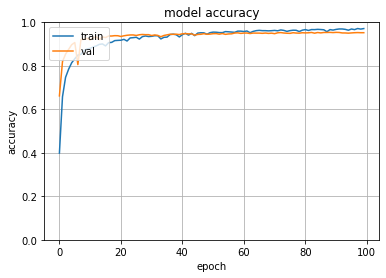

In [36]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.grid()
plt.legend(['train', 'val'], loc='upper left')
plt.show()

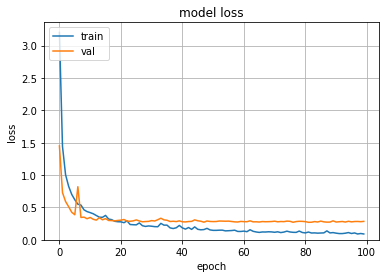

In [37]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(0, None)
plt.grid()
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Test model with Validation

In [38]:
# checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/kuzushiji-ml-it-kmitl-2020/model/cnn_weights.h5'
checkpoint_filepath = 'model/cnn_weights.h5'

In [39]:
# โหลด weight ที่ train ไว้
model = keras.models.load_model(checkpoint_filepath)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [40]:
# ทำนายผล
y_pred = np.argmax(model.predict(X_val), axis=-1)

In [41]:
# Training
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
print('Train - sparse_categorical_crossentropy: %.5f, accuracy: %.5f' % (loss, accuracy))

Train - sparse_categorical_crossentropy: 0.02939, accuracy: 0.99466


In [42]:
# Validation
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print('Validation - sparse_categorical_crossentropy: %.5f, accuracy: %.5f' % (loss, accuracy))

Validation - sparse_categorical_crossentropy: 0.22026, accuracy: 0.95867


In [44]:
print('accuracy: %.5f' % accuracy_score(y_val, y_pred))
print('precision: %.5f' % precision_score(y_val, y_pred, average="micro"))
print('recall: %.5f' % recall_score(y_val, y_pred, average="micro"))
print('f1_score: %.5f' % f1_score(y_val, y_pred, average="micro"))

accuracy: 0.95867
precision: 0.95867
recall: 0.95867
f1_score: 0.95867


In [45]:
print(classification_report(y_val, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.90909   1.00000   0.95238        30
           1    1.00000   1.00000   1.00000         2
           2    0.90000   0.90000   0.90000        10
           3    0.90000   1.00000   0.94737         9
           4    0.69231   0.81818   0.75000        11
           5    0.98507   1.00000   0.99248        66
           6    1.00000   1.00000   1.00000         3
           7    1.00000   1.00000   1.00000         2
           8    1.00000   1.00000   1.00000         6
           9    0.92308   1.00000   0.96000        12
          10    1.00000   0.98551   0.99270        69
          11    0.98361   0.95238   0.96774        63
          12    1.00000   1.00000   1.00000        15
          13    1.00000   0.66667   0.80000         3
          14    0.95181   0.98750   0.96933        80
          15    0.72727   0.88889   0.80000         9
          16    0.95652   1.00000   0.97778        44
          17    0.94737   1

C:\Users\user\anaconda3\envs\shine_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\envs\shine_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\envs\shine_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Load Test Data

In [46]:
# test_dataset = np.load('/content/drive/MyDrive/Colab Notebooks/kuzushiji-ml-it-kmitl-2020/test-images.npy')
test_dataset = np.load('test-images.npy')
test_dataset.shape

(25344, 64, 64)

ต้องเตรียมข้อมูลให้เหมือนกับชุด Training

In [47]:
X_test_dataset = test_dataset.reshape(-1, 4096)

In [48]:
X_test_dataset = X_test_dataset / 255

In [49]:
normalized_X_test_dataset = normalize(X_test_dataset)
np.std(normalized_X_test_dataset)

0.013619560309154876

In [51]:
X_norm_test_dataset = normalized_X_test_dataset.reshape(test_dataset.shape[0],test_dataset.shape[1],test_dataset.shape[2],1)
X_norm_test_dataset.shape

(25344, 64, 64, 1)

In [52]:
y_pred = np.argmax(model.predict(X_norm_test_dataset), axis=-1)
y_pred[:10]

array([412,  20, 241, 185, 557, 984, 915,  79, 332,  28], dtype=int64)

## Save the prediction 
นำผลทำนายมาเซฟไว้ในไฟล์ csv

In [53]:
index = np.arange(1, len(y_pred)+1)

In [54]:
d = {'ImageId': index, 'ClassId': y_pred}
df = pd.DataFrame(data=d)

In [55]:
df.head(10)

,ImageId,ClassId
0,1,412
1,2,20
2,3,241
3,4,185
4,5,557
5,6,984
6,7,915
7,8,79
8,9,332
9,10,28


In [56]:
# df.to_csv('/content/drive/MyDrive/Colab Notebooks/kuzushiji-ml-it-kmitl-2020/task1_CNN_predict_5.csv', index=False)
df.to_csv('predict_CNN.csv', index=False)